# Rotinas para a detecção das não-bijetividades

## Imports

In [1]:
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.insert(0,'..')
import lib.tf_levenberg_marquardt.levenberg_marquardt as lm
import tensorflow as tf
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers
from itertools import product
from time import time
from scipy.optimize import root
from functools import partial
from itertools import product
import polars as pl

## Funções

In [2]:
def nmse_error(y, y_hat):
    nmse = 10*np.log10(
        np.sum(np.abs(y-y_hat)**2)/
        np.sum(np.abs(y)**2)
        )
    return nmse

In [3]:
def load_csv2numpy(p):
    return np.loadtxt(p, delimiter=',', dtype=np.float32, skiprows=1)

In [4]:
def z2n(n):
    return n if n<0 else None

In [5]:
def prep_data_y(y, M, My=1):
    a0 = np.abs(y)
    end = z2n(-M-1)
    abs = [a0[:end],]
    for m in range(My-1):
        end = z2n(-M+m)
        abs.append(a0[m+1:end])
    abs = np.array(abs).T
    return abs

In [6]:
def prep_data(x, M):
    a0 = np.abs(x)
    abs = []
    size = x.shape[0]-M
    for m in range(1,size):
        abs.append(a0[m:m+M+1])
    abs = np.array(abs)

    p0 = np.angle(x)
    phase = []
    for m in range(1,size):
        phase.append(p0[m:m+M+1])
    phase = np.array(phase)
    
    delta = []
    for m in range(1,phase.shape[1]):
        delta.append(phase[:,m]-phase[:,m-1])
    delta = np.array(delta).T
    
    d_cos = np.cos(delta)
    d_sin = np.sin(delta)

    inputs = abs
    if M > 0:
        inputs = np.append(inputs, d_cos, axis=1)
        inputs = np.append(inputs, d_sin, axis=1)
    return inputs

In [7]:
def recuperar_data(s, x):
    y = s*np.exp(1j*np.angle(x))
    return y

In [8]:
def gerar_s(y, x, M=0):
    s = y*np.exp(-1j*np.angle(x))
    return s.real, s.imag

In [9]:
def normalize_data(x):
    return (x)/np.std(x)

In [10]:
def gen_model(M, HL, name, activation='tanh'):
    size_input = 1+3*(M)
    inputs = keras.Input(shape=(size_input,))
    hidden = layers.Dense(HL, activation=activation)(inputs)
    output = layers.Dense(1, activation='linear')(hidden)
    model = keras.Model(inputs=inputs, outputs=output, name=name)
    model = lm.ModelWrapper(model)
    model.call = tf.function(model.call)
    return model

In [11]:
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
        loss=lm.MeanSquaredError(),
        metrics=['accuracy','mse'],
        run_eargly=False)

In [12]:
def fit_model(model, epochs, inputs, s):
    history = model.fit(inputs, s, epochs=epochs, batch_size=3000, verbose=0)
    return history

In [13]:
def find_best_M_HL(x, y, M_min=0, M_max=10, HL_min=1, HL_max=10):    
    best_M = 0
    best_model = None
    best_nmse = np.inf
    best_y_hat = None
    metaparams = product(range(M_min,M_max+1), range(HL_min,HL_max+1))
    for M, HL in metaparams:
        start = time()
        inputs = prep_data(x, M)
        s_real, s_imag = gerar_s(y[M+1:], x[M+1:], M)

        model_real = gen_model(M, HL, 'parte_real')
        model_imag = gen_model(M, HL, 'parte_imag')

        compile_model(model_real)
        compile_model(model_imag)
        his = [0,0]
        his[0] = fit_model(model_real, 1000, inputs, s_real)
        his[1] = fit_model(model_imag, 1000, inputs, s_imag)
        
        model = (model_real, model_imag)
        # nmse = validation_models(model_real, model_imag, inputs, x, y)
        nmse, y_hat = validation(model, x, y, M)
        end = time()
        if nmse < best_nmse:
            best_nmse = nmse
            best_model = model
            best_M = M
            best_y_hat = y_hat
            print('*** BEST ***')
            print(f'Shape:{inputs.shape[1]} M:{M} HL:{HL} nmse:{nmse} time:{end-start}')
    return best_model, best_M, best_y_hat, best_nmse, his

In [14]:
def run_model(x, model, M):
    inputs = prep_data(x, M)
    # Modificado por questões de performance, o model.predict acaba ficando sem o ganho de usar o tf.function no modelo
    s_hat_real = model[0](inputs).numpy().reshape(-1,)
    s_hat_imag = model[1](inputs).numpy().reshape(-1,)

    s_hat = s_hat_real + 1j*s_hat_imag
    y_hat = recuperar_data(s_hat, x[M+1:])
    return y_hat

In [15]:
def validation(model, x, y, M):
    y_hat = run_model(x, model, M)
    nmse = nmse_error(y[M+1:], y_hat)
    return nmse, y_hat

## Plot das Inversas

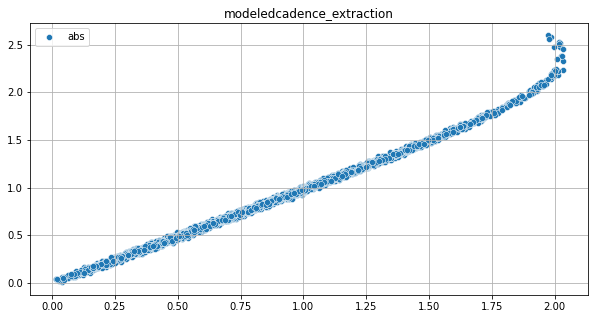

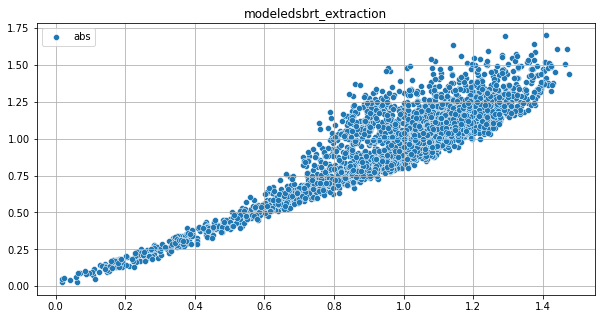

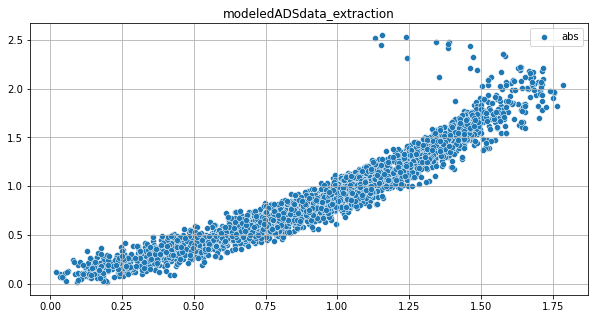

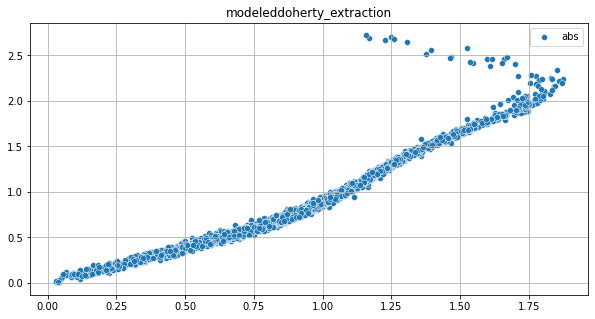

In [16]:
# plot inversa PA
for p in Path().glob('../data/*_extraction.csv'):
    data = load_csv2numpy(p)
 
    x = data[:, 2] + 1j*data[:, 3]
    x = normalize_data(x)
    x_abs = np.abs(x)

    y = data[:, 0] + 1j*data[:, 1]
    y = normalize_data(y)
    y_abs = np.abs(y)

    plt.figure(figsize=(10,5))
    sns.scatterplot(x=x_abs, y=y_abs, label='abs')
    plt.grid()
    plt.title(p.stem)
    plt.show()
    plt.close()

    # best_model, M = find_best_M_HL(x, y, M_min=3, M_max=20, HL_min=5, HL_max=20)
    '''
    pv = p.parent/p.parts[-1].replace('extraction', 'validation')
    data = load_csv2numpy(pv)

    x = data[:, 0] + 1j*data[:, 1]
    x = normalize_data(x)
    y = data[:, 2] + 1j*data[:, 3]
    y = normalize_data(y)

    nmse = validation(best_model, x, y, M)
    '''

## Treinamento da Rede Neural

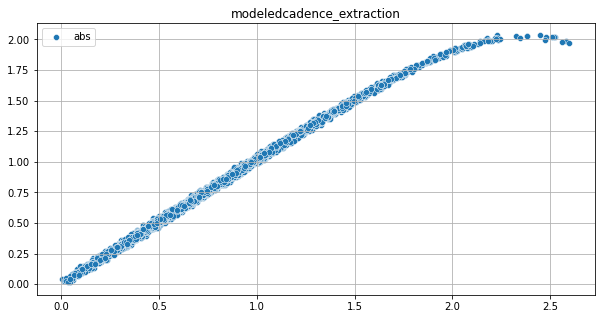

*** BEST ***
Shape:10 M:3 HL:7 nmse:-60.699944496154785 time:189.13501477241516
nmse - extraction: -60.699944496154785
nmse - validation: -42.30689525604248


In [18]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

plt.figure(figsize=(10,5))
ax = sns.scatterplot(x=x_abs, y=y_abs, label='abs')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

M = 3
HL = 7

model, M, y_hat, nmse, his = find_best_M_HL(x, y, M_min=M, M_max=M, HL_min=HL, HL_max=HL)
print(f'nmse - extraction: {nmse}')

pv = p.parent/p.parts[-1].replace('extraction', 'validation')
data = load_csv2numpy(pv)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, _ = validation(model, x, y, M)
print(f'nmse - validation: {nmse}')

## Carregando Rede Neural

In [16]:
model = [0,0]
M = 3
HL = 7
model[0] = gen_model(M, HL, 'parte_real', activation='tanh')
model[1] = gen_model(M, HL, 'parte_imag', activation='tanh')

model[0].load_weights('./weights/modeledcadence_extraction_real2');
model[1].load_weights('./weights/modeledcadence_extraction_imag2');

model_PA = model

## Validação do Modelo

nmse - extraction: -42.87520408630371


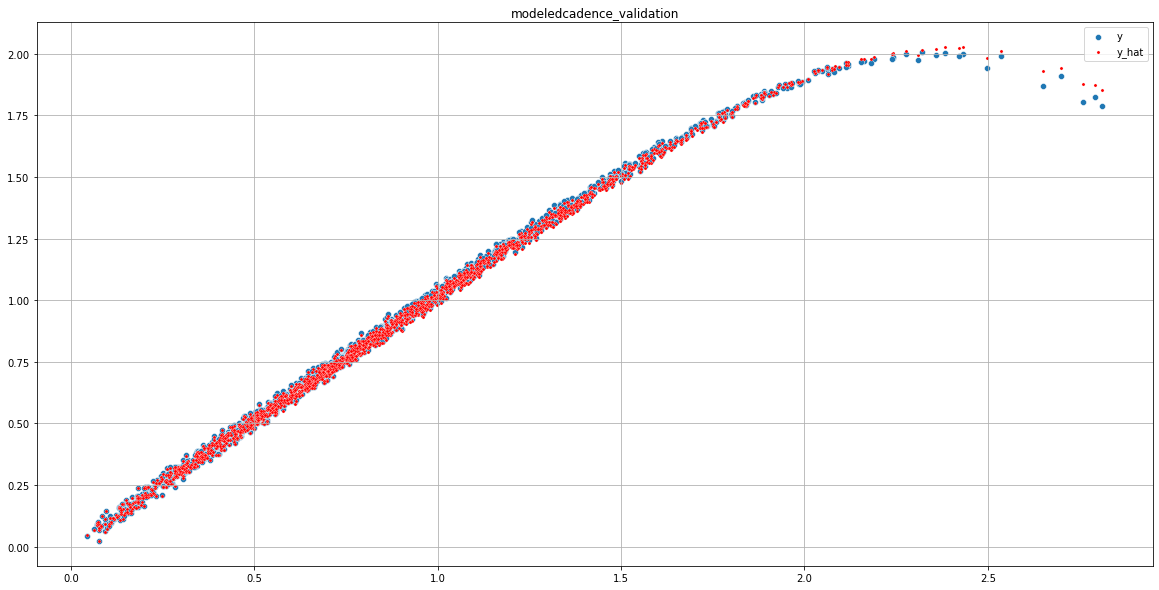

In [17]:
p = Path('../data/modeledcadence_validation.csv')
data = load_csv2numpy(p)
x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, y_hat = validation(model, x, y, M)
print(f'nmse - extraction: {nmse}')

plt.figure(figsize=(20,10))
sns.scatterplot(x=x_abs, y=y_abs, label='y')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='y_hat', s=10, color='red')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

nmse - extraction: -60.90199947357178


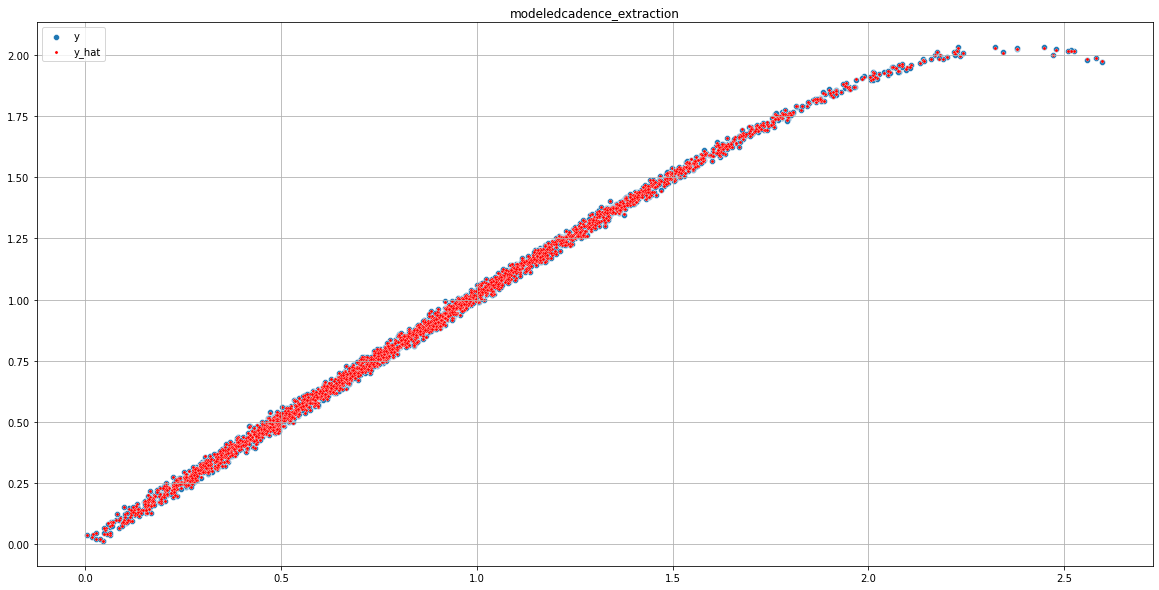

In [18]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)
x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, y_hat = validation(model, x, y, M)
print(f'nmse - extraction: {nmse}')

plt.figure(figsize=(20,10))
sns.scatterplot(x=x_abs, y=y_abs, label='y')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='y_hat', s=10, color='red')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

## Problema Inverso

In [19]:
def inverse_problem(x, y, model, M, x_old, exp=False):
    if exp:
        x = np.array([x[0]*np.exp(1j*x[1])])
    else:
        x = np.array([x[0]+1j*x[1]])
    
    if np.abs(x) > 3:
        gama = np.abs(x)
    else:
        gama = 1
    x = np.concatenate([x_old, x])

    y_hat = run_model(x, model, M)

    y_real, y_imag = y_hat.real, y_hat.imag
    output = np.array([y.real - y_real, y.imag - y_imag]).reshape(-1,)
    output *= gama
    return output

In [74]:
def solve_inverse_problem(n, x, x_n, xs, x_abs, M, model, r_model, exp=True):
    if n<M+1:
        return

    if x_abs[n] < 1:
        return

    xt = x[n-M-1:n+1] # Valores de x para extrair o y0
    x_old = xt[:-1] # Valores de x antigos
    x_a = xt[-1].reshape(-1,) # Valor de x atual
    y0 = r_model(x=xt) # Extração do y0

    #print(f'inicia o problema inverso nº {n}')

    # Problema inverso
    i_problem = partial(inverse_problem, model=model, M=M, y=y0, x_old=x_old, exp=exp)
    res = []
    for x0 in xs:
        res.append(root(i_problem, x0=x0))

    # Erro
    # print(f'x:   {x_a}')
    results = dict()
    for i, x0 in enumerate(xs):
        x0 = x0[0]*np.exp(1j*x0[1]).reshape(-1,)
        new_x0 = (res[i].x[0]*np.exp(1j*res[i].x[1])).reshape(-1,)
        new_y0 = r_model(x=np.concatenate([x_old, new_x0]))
        error_y0 = nmse_error(y0, new_y0)
        error_x0 = nmse_error(x_a, new_x0)
        #print(f'x0{i}: {x0} -> {new_x0} -> {np.abs(new_x0)} -> {error_y0} -> {error_x0}')
        results[i] = {'error_y0': error_y0, 'error_x0': error_x0}
    return results

In [58]:
r_model = partial(run_model, model=model, M=M)
x01 = np.array([-2.0,2.0]) # Chute inicial de x0
x02 = np.array([2.0,-2.0]) # Chute inicial de x0
x03 = np.array([-0.5,0.5]) # Chute inicial de x0
x04 = np.array([0.5,-0.5]) # Chute inicial de x0
xs = [x01, x02, x03, x04]
results_ri = dict()

for n, x_n in enumerate(x):
    if n<M+1:
        continue
    if x_abs[n] < 2:
        continue

    x_old = x[n-M-1:n] # Valores de x antigos
    x_a = x[n].reshape(-1,) # Valor de x atual

    xt = x[n-M-1:n+1] # Valores de x para extrair o y0
    y0 = r_model(x=xt) # Extração do y0

    print(f'inicia o problema inverso nº {n}')

    # Problema inverso
    i_problem = partial(inverse_problem, model=model, M=M, y=y0, x_old=x_old)
    res = []
    for i, x0 in enumerate(xs):
        res.append(root(i_problem, x0=x0))

    # Erro
    print(f'x:   {x_a} -> {np.abs(x_a)}')
    results_ri[n] = dict()
    for i, x0 in enumerate(xs):
        x0 = (x0[0]+1j*x0[1]).reshape(-1,)
        new_x0 = (res[i].x[0]+1j*res[i].x[1]).reshape(-1,)
        new_y0 = r_model(x=np.concatenate([x_old, new_x0]))
        error_y0 = nmse_error(y0, new_y0)
        error_x0 = nmse_error(x_a, new_x0)
        #print(f'x0{i}: {x0} -> {new_x0} -> {np.abs(new_x0)} -> {error_y0} -> {error_x0}')
        results_ri[n][i] = {'error_y0': error_y0, 'error_x0': error_x0}
    print()

inicia o problema inverso nº 4
x:   [-0.19629194+0.56892234j] -> [0.60183316]

inicia o problema inverso nº 5
x:   [-0.23159243+0.51077473j] -> [0.56082606]

inicia o problema inverso nº 6
x:   [-0.22681312+0.38029885j] -> [0.4427995]

inicia o problema inverso nº 7
x:   [-0.1769677+0.1850784j] -> [0.25606948]

inicia o problema inverso nº 8
x:   [-0.08379133-0.05951062j] -> [0.10277403]

inicia o problema inverso nº 9
x:   [0.04559788-0.3320429j] -> [0.33515915]

inicia o problema inverso nº 10
x:   [0.20060046-0.6078029j] -> [0.6400507]

inicia o problema inverso nº 11
x:   [0.36859277-0.86308014j] -> [0.9384924]

inicia o problema inverso nº 12
x:   [0.53680426-1.0757775j] -> [1.2022712]

inicia o problema inverso nº 13
x:   [0.69298756-1.2275758j] -> [1.4096717]

inicia o problema inverso nº 14
x:   [0.82530975-1.3047425j] -> [1.5438553]

inicia o problema inverso nº 15
x:   [0.92191464-1.2989491j] -> [1.5928576]

inicia o problema inverso nº 16
x:   [0.9717826-1.2089075j] -> [1.55

In [75]:
r_model = partial(run_model, model=model, M=M)
x01 = np.array([0.5,0*np.pi/4]) # Chute inicial de x0
x02 = np.array([0.5,1*np.pi/4]) # Chute inicial de x0
x03 = np.array([0.5,2*np.pi/4]) # Chute inicial de x0
x04 = np.array([0.5,3*np.pi/4]) # Chute inicial de x0
x05 = np.array([0.5,4*np.pi/4]) # Chute inicial de x0
x06 = np.array([0.5,5*np.pi/4]) # Chute inicial de x0
x07 = np.array([0.5,6*np.pi/4]) # Chute inicial de x0
x08 = np.array([0.5,7*np.pi/4]) # Chute inicial de x0
xs = [x01, x02, x03, x04, x05, x06, x07, x08]
results_fa = dict()

for n, x_n in enumerate(x):
    if (result := solve_inverse_problem(n, x, x_n, xs, x_abs, M, model, r_model, exp=True)):
        results_fa[n] = result

In [65]:
r_model = partial(run_model, model=model, M=M)
x01 = np.array([2,0*np.pi/4]) # Chute inicial de x0
x02 = np.array([2,1*np.pi/4]) # Chute inicial de x0
x03 = np.array([2,2*np.pi/4]) # Chute inicial de x0
x04 = np.array([2,3*np.pi/4]) # Chute inicial de x0
x05 = np.array([2,4*np.pi/4]) # Chute inicial de x0
x06 = np.array([2,5*np.pi/4]) # Chute inicial de x0
x07 = np.array([2,6*np.pi/4]) # Chute inicial de x0
x08 = np.array([2,7*np.pi/4]) # Chute inicial de x0
xs = [x01, x02, x03, x04, x05, x06, x07, x08]
results_fa = dict()

for n, x_n in enumerate(x):
    if n<M+1:
        continue
    if x_abs[n] < 1:
        continue

    xt = x[n-M-1:n+1] # Valores de x para extrair o y0
    x_old = xt[:-1] # Valores de x antigos
    x_a = xt[-1].reshape(-1,) # Valor de x atual

    y0 = r_model(x=xt) # Extração do y0

    #print(f'inicia o problema inverso nº {n}')

    # Problema inverso
    i_problem = partial(inverse_problem, model=model, M=M, y=y0, x_old=x_old, exp=True)
    res = []
    for x0 in xs:
        res.append(root(i_problem, x0=x0))

    # Erro
    #print(f'x:   {x_a}')
    results_fa[n] = dict()
    for i, x0 in enumerate(xs):
        x0 = x0[0]*np.exp(1j*x0[1]).reshape(-1,)
        new_x0 = (res[i].x[0]*np.exp(1j*res[i].x[1])).reshape(-1,)
        new_y0 = r_model(x=np.concatenate([x_old, new_x0]))
        error_y0 = nmse_error(y0, new_y0)
        error_x0 = nmse_error(x_a, new_x0)
        #print(f'x0{i}: {x0} -> {new_x0} -> {np.abs(new_x0)} -> {error_y0} -> {error_x0}')
        results_fa[n][i] = {'error_y0': error_y0, 'error_x0': error_x0}
    #print()

## Analise Resultados

In [ ]:
def plot_errors(results, chute, x0, ax):
    teste_x0 = [results[r][chute] for r in results]
    ex0, ey0 = list(zip(*[(k['error_x0'], k['error_y0']) for k in teste_x0]))
    sns.scatterplot(x=ex0, y=ey0, ax=ax)
    plt.xlabel('Erro em X')
    plt.ylabel('Erro em y')
    plt.title(f'Chute inicial {chute}: {x0}')
    plt.grid()

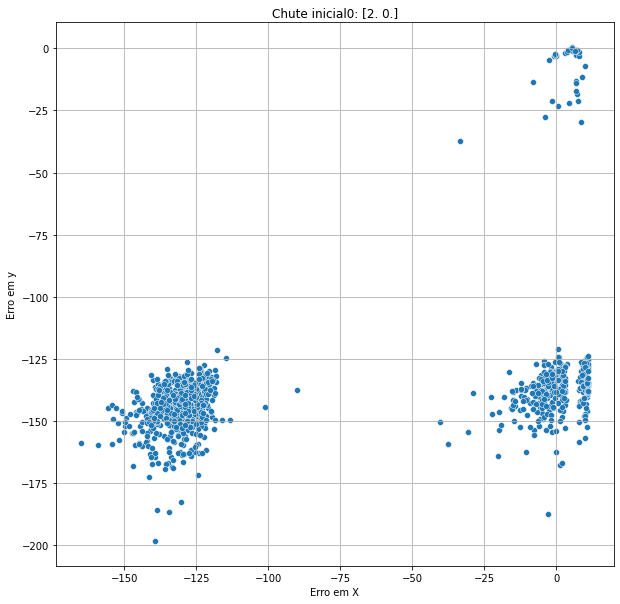

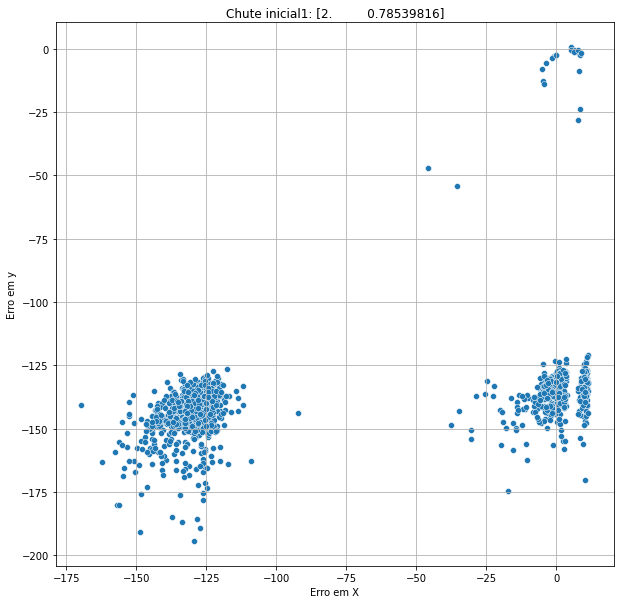

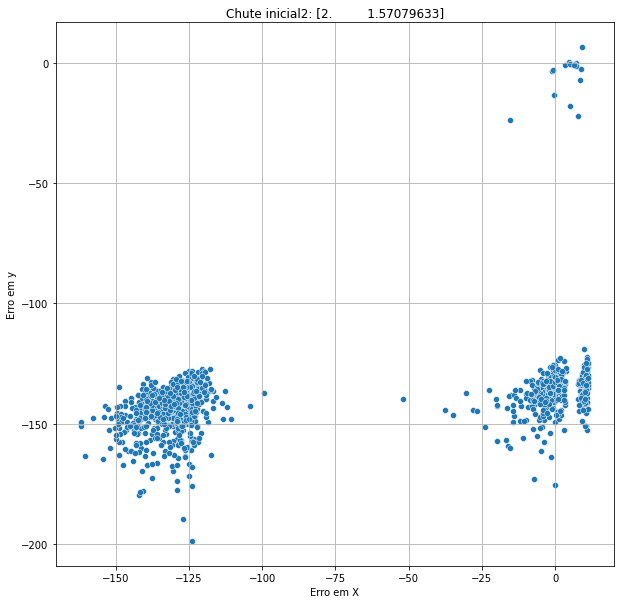

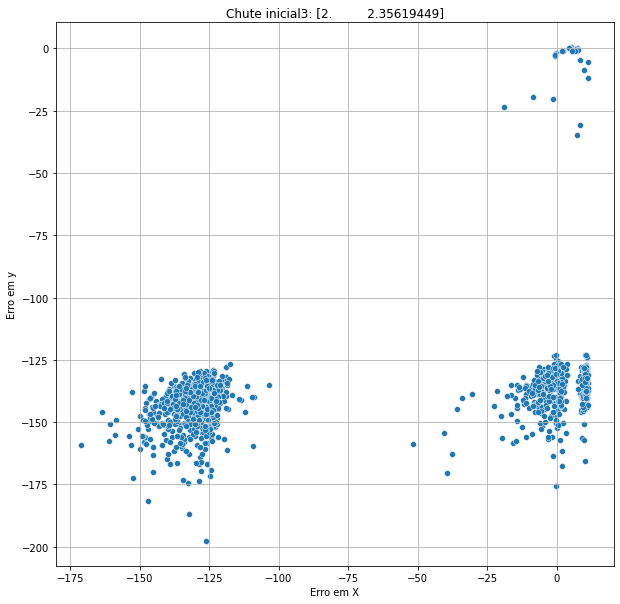

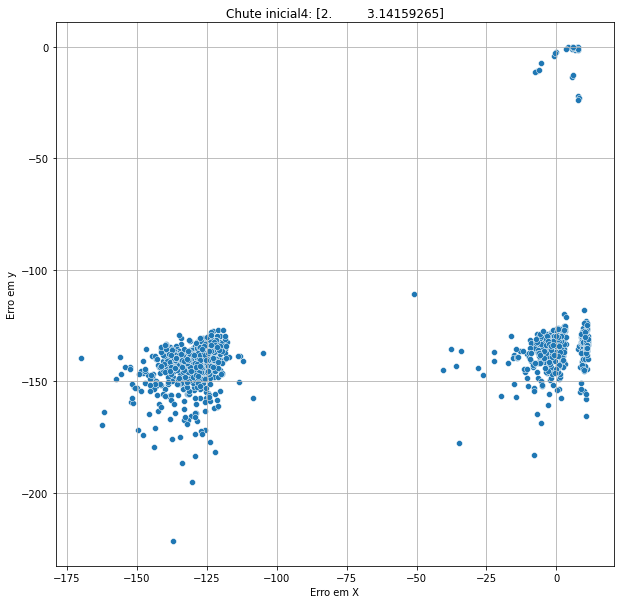

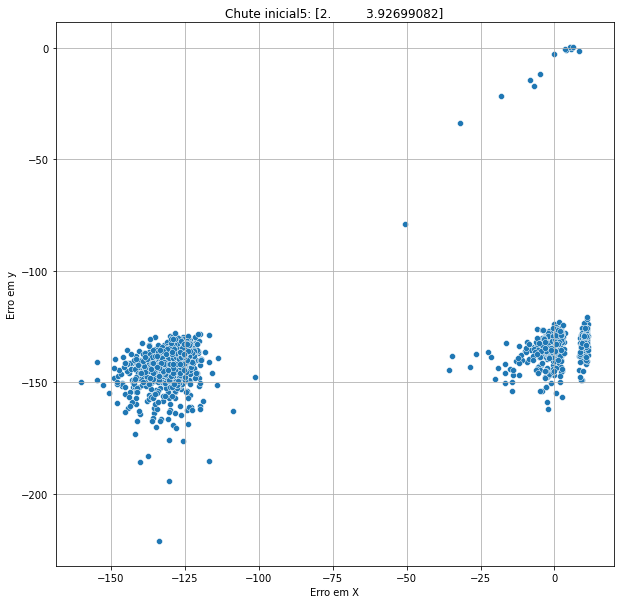

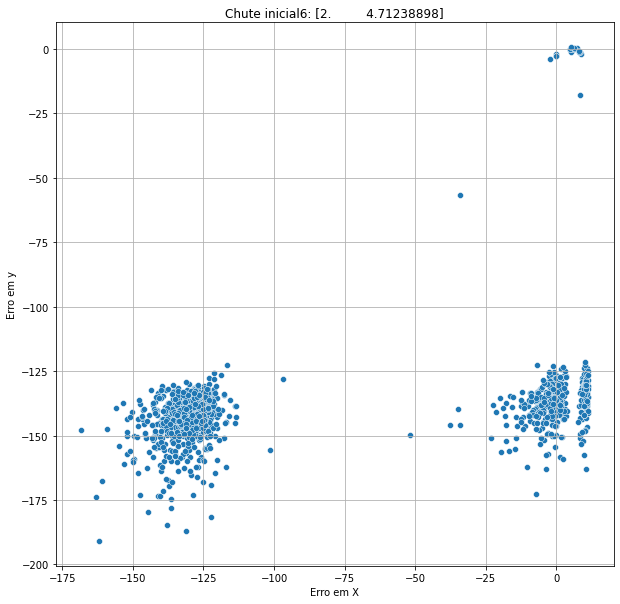

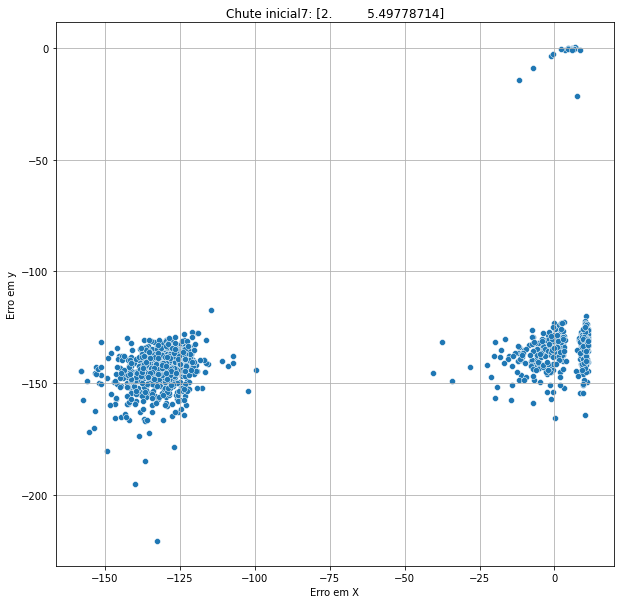

In [ ]:
plt.figure(figsize=(20,40))

f, axes = plt.subplots(4,2)
for i, x0, ax in zip(enumerate(xs), axes.flatten()):
    plot_errors(results_fa, i, x0, ax)

plt.show()
plt.close()

## Continuidade do modelo em NN

In [43]:
# Teste de curva
r_model = partial(run_model, model=model, M=M)
n = 2036
x_old = x[n-M-1:n] # Valores de x antigos
ylist = []
xlist = []
for n in range(1,100,1):
    n = n/10
    x0 = n*np.exp(1j*np.pi/4).reshape(-1,)
    y0 = r_model(x=np.concatenate([x_old, x0])) # Extração do y0
    xlist.append(x0)
    ylist.append(y0)

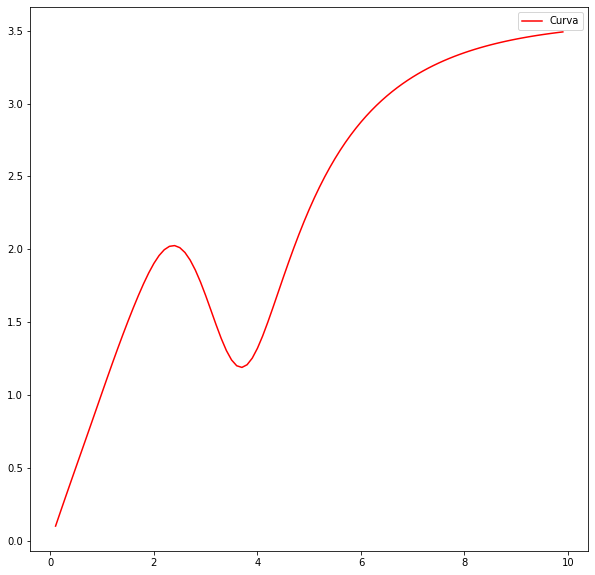

In [44]:
plt.figure(figsize=(10,10))
xlist = np.array(xlist).reshape(-1,)
ylist = np.array(ylist).reshape(-1,)
sns.lineplot(x=np.abs(xlist), y=np.abs(ylist), color='red', label='Curva')
plt.show()
plt.close()

## Mesmo x para diferentes memórias

In [24]:
# Teste de curva
r_model = partial(run_model, model=model, M=M)
x0 = 1.5*np.exp(1j*np.pi/4).reshape(-1,)
ylist = []
tlist = []
for t in range(10,x.shape[0],1):
    x_old = x[t-M-1:t] # Valores de x antigos
    y0 = r_model(x=np.concatenate([x_old, x0])) # Extração do y0
    tlist.append(t)
    ylist.append(y0)

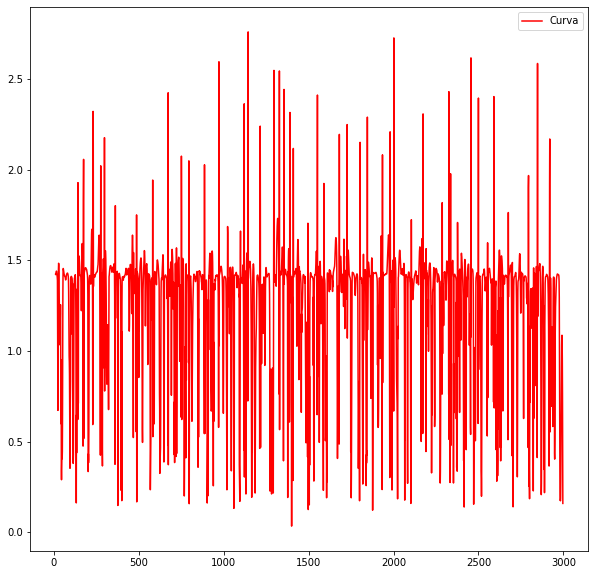

In [25]:
plt.figure(figsize=(10,10))
tlist = np.array(tlist).reshape(-1,)
ylist = np.array(ylist).reshape(-1,)
sns.lineplot(x=np.abs(tlist), y=np.abs(ylist), color='red', label='Curva')
plt.show()
plt.close()

## Efeito da entrada para o problema inverso

In [45]:
r_model = partial(run_model, model=model, M=M)
n = 2036
x_n = x[n]
x_old = x[n-M-1:n]
x_a = x[n].reshape(-1,)
xt = x[n-M-1:n+1] # Valores de x para extrair o y0
y0 = r_model(x=xt) # Extração do y0
i_problem = partial(inverse_problem, model=model, M=M, y=y0, x_old=x_old)

values = np.array( list(product(range(30,-30,-1), range(-30,30,1)))).reshape(-1,2)/10

In [46]:
res = []
for i, x0 in enumerate(values):
    res.append(root(i_problem, x0=x0))

x:   [1.6268898-2.004946j] -> [2.581972]


In [51]:
x0s = [r.x for r in res]
e0s = [r.fun for r in res]
a0s = [x[0]+1j*x[1] for x in x0s]
a0s = np.abs(np.array(a0s)).reshape(-1,1)
e0s = (np.sum(np.array(e0s)**2, axis=1)**0.5).reshape(-1,1)
t0s = np.where(e0s<0.1, a0s, 0)
v0s = np.concatenate([values, a0s, e0s, t0s], axis=1)
dfv = pl.DataFrame(v0s, columns=['real', 'imag', 'abs', 'erro', 'teste'])

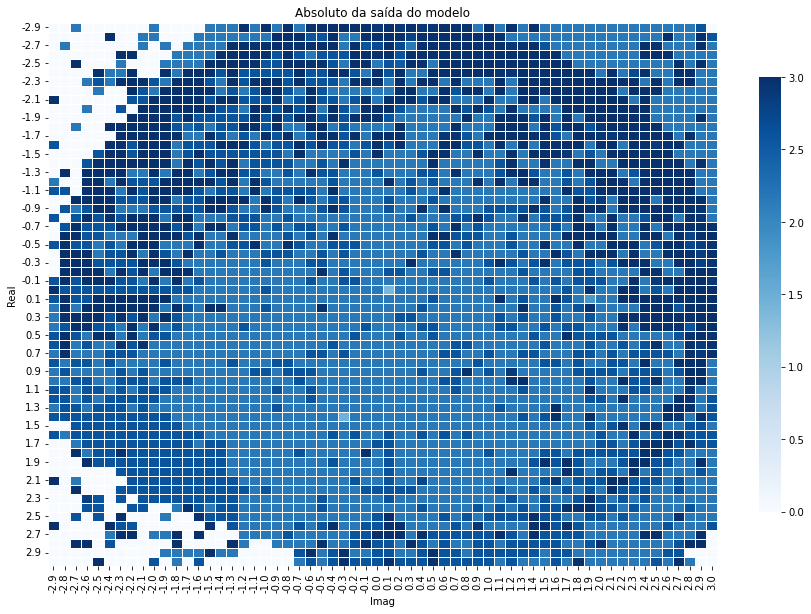

In [52]:
dfpdv = dfv[['real', 'imag', 'abs']].to_pandas()
dfpdv.set_index(['real', 'imag'], inplace=True)
dfunstack = dfpdv.unstack()
plt.figure(figsize=(15,10))
sns.heatmap(dfunstack, cmap="Blues", vmin=0, vmax=3, linewidth=1, cbar_kws={"shrink": .8})
plt.xticks(np.arange(60) + .5, labels=dfunstack.index)
plt.xlabel('Imag')
plt.ylabel('Real')
plt.title('Absoluto da saída do modelo')
plt.show()
plt.close()

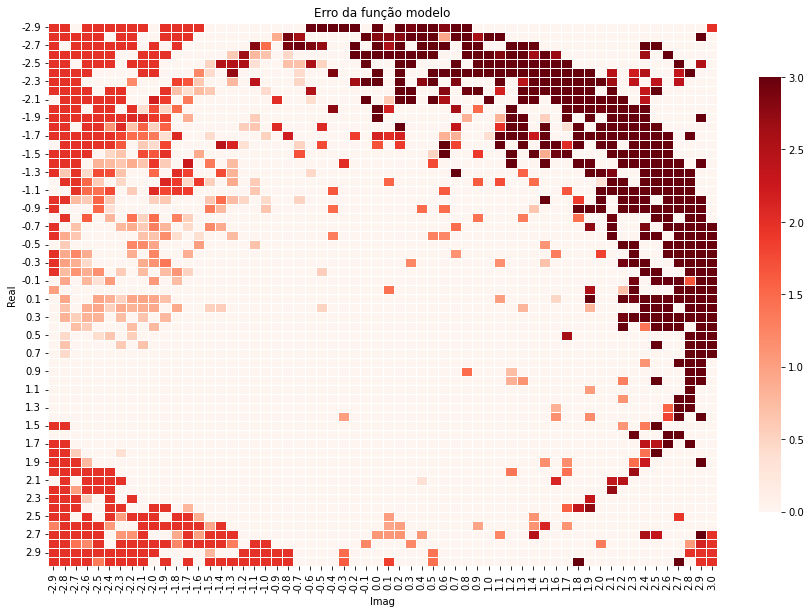

In [53]:
dfpdv = dfv[['real', 'imag', 'erro']].to_pandas()
dfpdv.set_index(['real', 'imag'], inplace=True)
dfunstack = dfpdv.unstack()
plt.figure(figsize=(15,10))
sns.heatmap(dfunstack, cmap="Reds", vmin=0, vmax=3, linewidth=1, cbar_kws={"shrink": .8})
plt.xticks(np.arange(60) + .5, labels=dfunstack.index)
plt.xlabel('Imag')
plt.ylabel('Real')
plt.title('Erro da função modelo')
plt.show()
plt.close()

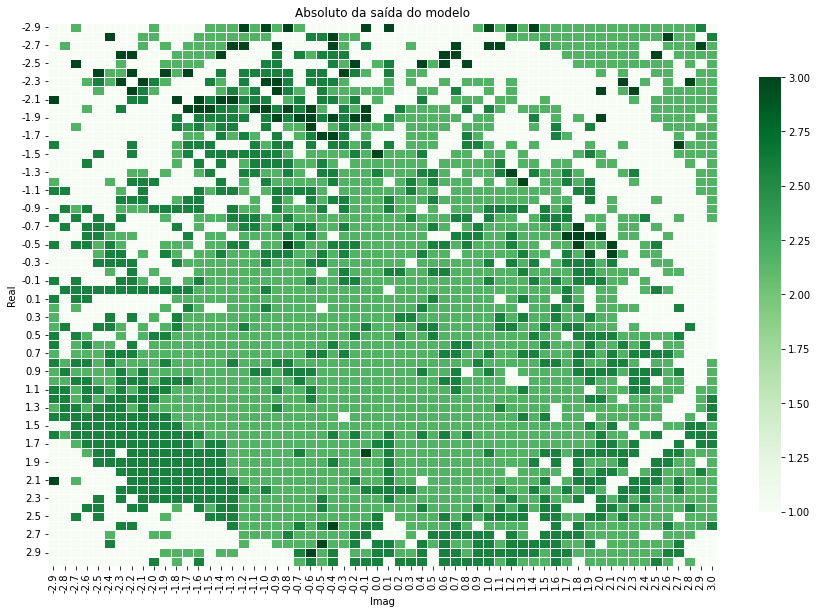

In [54]:
dfpdv = dfv[['real', 'imag', 'teste']].to_pandas()
dfpdv.set_index(['real', 'imag'], inplace=True)
dfunstack = dfpdv.unstack()
plt.figure(figsize=(15,10))
sns.heatmap(dfunstack, cmap="Greens", vmin=1, vmax=3, linewidth=1, cbar_kws={"shrink": .8})
plt.xticks(np.arange(60) + .5, labels=dfunstack.index)
plt.xlabel('Imag')
plt.ylabel('Real')
plt.title('Absoluto da saída do modelo')
plt.show()
plt.close()

## Treinamento da inversa

In [20]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

x = data[:, 2] + 1j*data[:, 3]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 0] + 1j*data[:, 1]
y = normalize_data(y)
y_abs = np.abs(y)

print(y_abs.max())
print(x_abs.max())

M = 3
HL = 7

model_Inv, M, y_hat, nmse, his = find_best_M_HL(x, y, M_min=M, M_max=M, HL_min=HL, HL_max=HL)
print(f'nmse - extraction: {nmse}')

pv = p.parent/p.parts[-1].replace('extraction', 'validation')
data = load_csv2numpy(pv)

x = data[:, 2] + 1j*data[:, 3]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 0] + 1j*data[:, 1]
y = normalize_data(y)
y_abs = np.abs(y)

print(y_abs.max())
print(x_abs.max())

nmse, y_hat = validation(model_Inv, x, y, M)
print(f'nmse - validation: {nmse}')

2.5961926
2.0323806
*** BEST ***
Shape:10 M:3 HL:7 nmse:-46.97522163391113 time:137.11702632904053
nmse - extraction: -46.97522163391113
2.810668
2.0061333
nmse - validation: -25.051989555358887


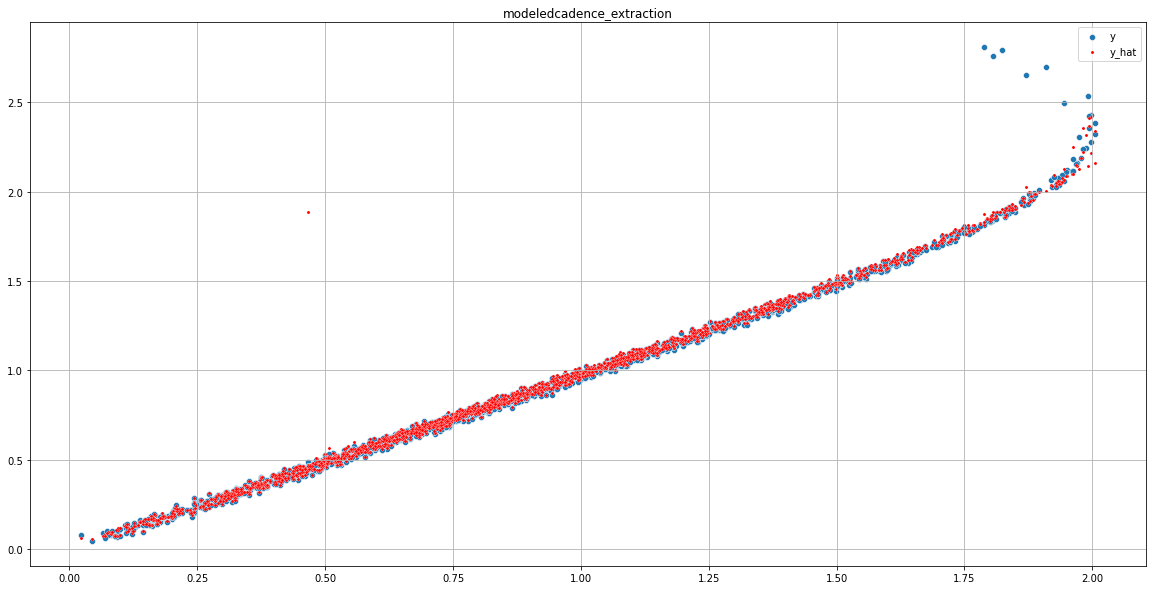

In [21]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=x_abs, y=y_abs, label='y')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='y_hat', s=10, color='red')
plt.grid()
plt.title(pv.stem)
plt.show()
plt.close()

In [23]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

M = 3
HL = 7

y = data[:, 0] + 1j*data[:, 1]
y = 0.7*normalize_data(y)
y_abs = np.abs(y)
print(y_abs.max())

x = run_model(y, model_PA, M)
x_abs = np.abs(x)

print(x_abs.max())

model_Inv, M, y_hat, nmse, his = find_best_M_HL(x, y[M+1:], M_min=M, M_max=M, HL_min=HL, HL_max=HL)
print(f'nmse - extraction: {nmse}')

pv = p.parent/p.parts[-1].replace('extraction', 'validation')
data = load_csv2numpy(pv)

y = data[:, 0] + 1j*data[:, 1]
y = 0.7*normalize_data(y)
y_abs = np.abs(y)
print(y_abs.max())

x = run_model(y, model_PA, M)
x_abs = np.abs(x)

print(x_abs.max())

nmse, y_hat = validation(model_Inv, x, y[M+1:], M)
print(f'nmse - validation: {nmse}')

1.8173348
1.7771702
*** BEST ***
Shape:10 M:3 HL:7 nmse:-59.02649402618408 time:198.70256066322327
nmse - extraction: -59.02649402618408
1.9674675
1.8780648
nmse - validation: -54.95192527770996


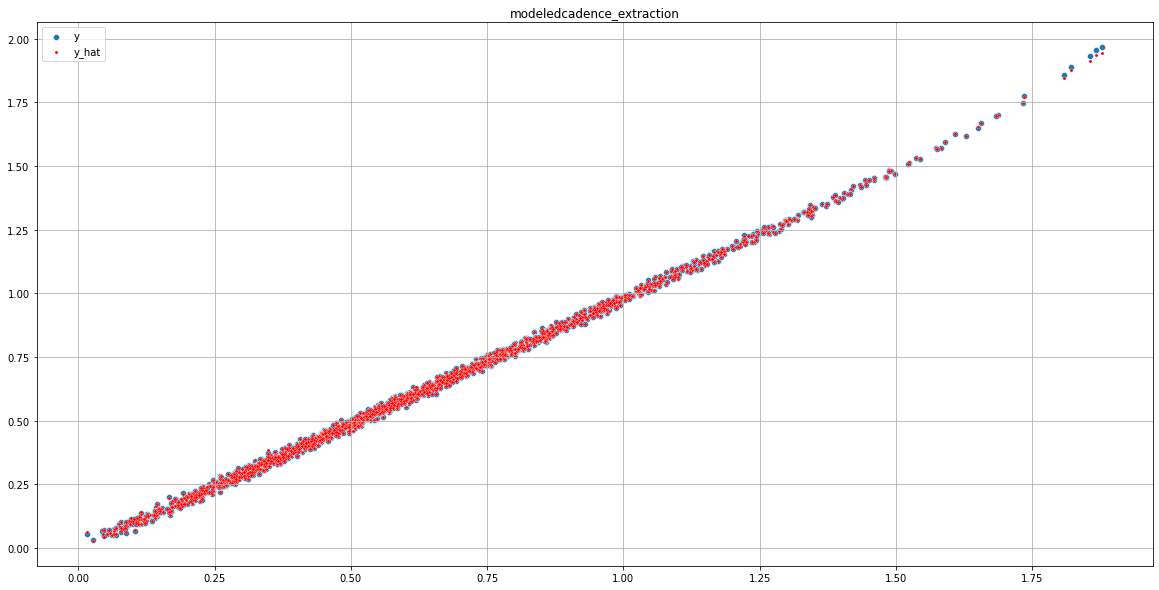

In [24]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=x_abs, y=y_abs[M+1:], label='y')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='y_hat', s=10, color='red')
plt.grid()
plt.title(pv.stem)
plt.show()
plt.close()

In [27]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

M = 3
HL = 7

y = data[:, 0] + 1j*data[:, 1]
y = normalize_data(y)
y_abs = np.abs(y)
print(y_abs.max())

x = run_model(y, model_PA, M)
x_abs = np.abs(x)

print(x_abs.max())

model_Inv, M, y_hat, nmse, his = find_best_M_HL(x, y[M+1:], M_min=M, M_max=M, HL_min=HL, HL_max=HL)
print(f'nmse - extraction: {nmse}')

pv = p.parent/p.parts[-1].replace('extraction', 'validation')
data = load_csv2numpy(pv)

y = data[:, 0] + 1j*data[:, 1]
y = normalize_data(y)
y_abs = np.abs(y)
print(y_abs.max())

x = run_model(y, model_PA, M)
x_abs = np.abs(x)

print(x_abs.max())

nmse, y_hat = validation(model_Inv, x, y[M+1:], M)
print(f'nmse - validation: {nmse}')

2.5961926
2.0290694
*** BEST ***
Shape:10 M:3 HL:7 nmse:-40.88686943054199 time:143.36403131484985
nmse - extraction: -40.88686943054199
2.810668
2.0273118
nmse - validation: -26.54186487197876


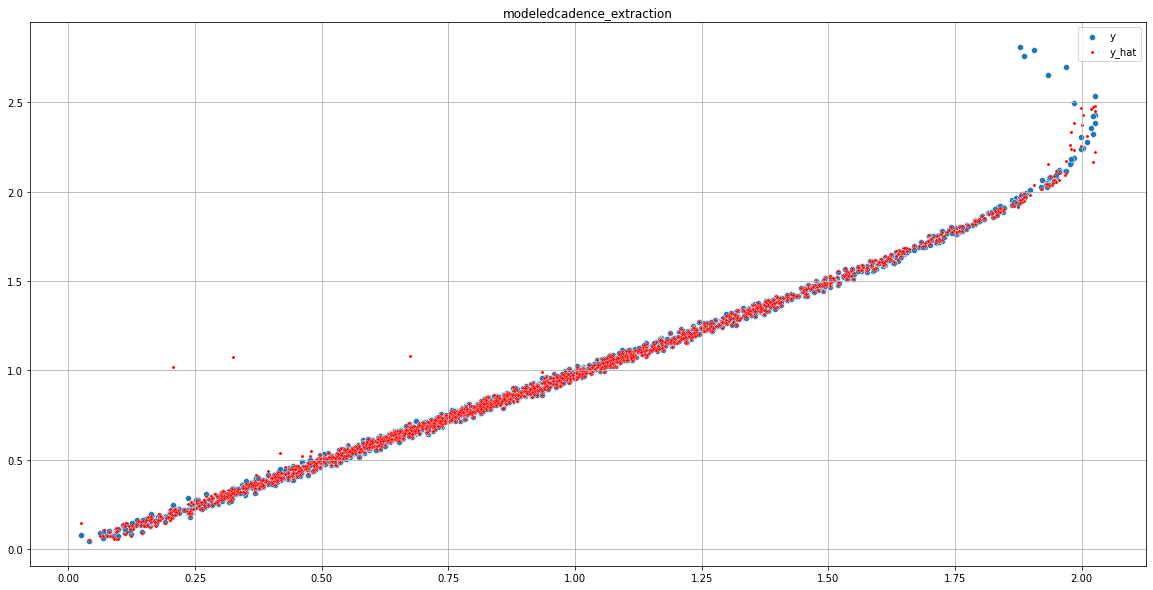

In [28]:
plt.figure(figsize=(20,10))
sns.scatterplot(x=x_abs, y=y_abs[M+1:], label='y')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='y_hat', s=10, color='red')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

- Testar o treinamento da inversa da rede para um modelo com ou sem inversa